In [1]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv -O sunspots.csv

--2020-01-05 09:16:22--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.194.176
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.194.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘sunspots.csv’

sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.03s   

2020-01-05 09:16:23 (2.37 MB/s) - ‘sunspots.csv’ saved [70827/70827]



In [6]:
import csv
import numpy as np

time_step = []
sunspots = []

with open("sunspots.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    next(reader)
    for row in reader:
        # ind, date, mean sunspot num per month
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))
        
series = np.array(sunspots)
time = np.array(time_step)

In [9]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# My own try below:

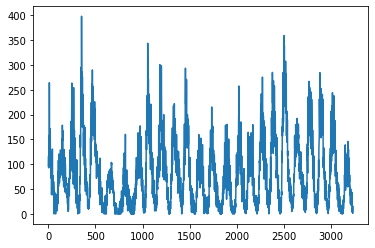

In [7]:
import matplotlib.pyplot as plt
plt.plot(time, series)b

19.874988814317668

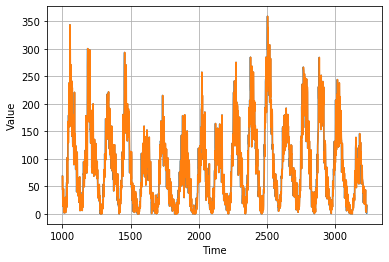

In [31]:
baseline = series[split_time-1:-1]

plot_series(time_valid, x_valid)
plot_series(time_valid, baseline)
tf.keras.metrics.mean_absolute_error(x_valid, baseline).numpy()

In [11]:
import tensorflow as tf
tf.__version__

'2.0.0-dev20191002'

In [22]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/lecture/jS8XX/preparing-features-and-labels
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # basically np -> tf
    # 0
    # 1
    # 2
    # 3
    # 4
    # 5
    # 6
    # 7
    # 8
    # 9
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # 0 1 2 3 4 
    # 1 2 3 4 5 
    # 2 3 4 5 6 
    # 3 4 5 6 7 
    # 4 5 6 7 8 
    # 5 6 7 8 9
    ## 6 7 8 9
    ## 7 8 9
    ## 8 9
    ## 9
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # [0 1 2 3 4] 
    # [1 2 3 4 5] 
    # [2 3 4 5 6] 
    # [3 4 5 6 7] 
    # [4 5 6 7 8] 
    # [5 6 7 8 9]
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # [0 1 2 3] [4] 
    # [1 2 3 4] [5] 
    # [2 3 4 5] [6] 
    # [3 4 5 6] [7] 
    # [4 5 6 7] [8] 
    # [5 6 7 8] [9]
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [14]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [26]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
#     tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

In [ ]:
forecast = []
for time in range(len(series)-window_size):
    curPredict = model.predict(series[time:time+window_size][np.newaxis])
    forecast.append(curPredict)
results = np.array(forecast[split_time-window_size:])[:, 0, 0]

18.643942

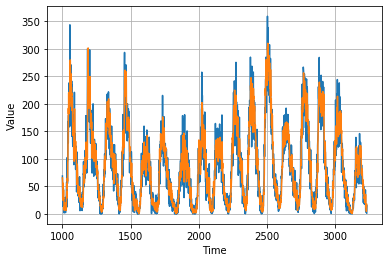

In [29]:
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()